<a href="https://colab.research.google.com/github/GitHub-Bong/Toxic-Comment-Challenge/blob/master/0402_baseline_model_Revision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount , Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
import sys, os, re, string, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

------------------

# Load Data

In [ ]:
train = pd.read_csv('/content/drive/Shareddrives/SOGANG Parrot/train.csv/train.csv')
test = pd.read_csv('/content/drive/Shareddrives/SOGANG Parrot/test.csv/test.csv')

In [ ]:
train.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0


In [ ]:
train.isnull().any(), test.isnull().any()

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool, id              False
 comment_text    False
 dtype: bool)

------------

# Preprocessing

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

train['comment_text'] = train['comment_text'].apply(lambda x: clean_text(x))
test['comment_text'] = test['comment_text'].apply(lambda x: clean_text(x))

In [ ]:
train['comment_text'].head(3)

0    explanationwhy the edits made under my usernam...
1    daww he matches this background colour im seem...
2    hey man im really not trying to edit war its j...
Name: comment_text, dtype: object

In [ ]:
test['comment_text'].head(3)

0    yo bitch ja rule is more succesful then youll ...
1            from rfc   the title is fine as it is imo
2              sources    zawe ashton on lapland —    
Name: comment_text, dtype: object

In [ ]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values # y.shape (159571, 6)
list_sentences_train = train["comment_text"] # (159571,)
list_sentences_test = test["comment_text"] # (153164,)

In [ ]:
list_sentences_train[0]

'explanationwhy the edits made under my username hardcore metallica fan were reverted they werent vandalisms just closure on some gas after i voted at new york dolls fac and please dont remove the template from the talk page since im retired '

------------

# Tokenization

In [ ]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
# list_tokenized_train[:1] = [[688,75,1,126,130, ,,, ]]
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
# list_tokenized_test[:1] = [[2665,655,8849,656, ,,, ]]

# tokenizer.word_counts = OrderedDict([('explanation', 1771),('why', 17818),('the', 496540),('edits', 9957), ,,, ])
# tokenizer.word_index = {'the': 1,'to': 2,'of': 3,'and': 4, ,,, }

In [ ]:
len(tokenizer.word_index)

268591

------------

# Padding

In [ ]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen) # (159571, 200)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen) # (153164, 200)

-------------

# Pretrained-Embedding-matrix

In [ ]:
embedding_dict = dict()
f = open('/content/drive/Shareddrives/SOGANG Parrot/Pretrained-Embedding-Vector/glove.twitter.27B.25d.txt/glove.twitter.27B.25d.txt', encoding="utf8")

for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 100
    embedding_dict[word] = word_vector_arr
f.close()
print('There are %s Embedding Vectors\n' % len(embedding_dict))

print(embedding_dict['respectable'])
print(len(embedding_dict['respectable']))

for word, i in tokenizer.word_index.items(): 
    temp = embedding_dict.get(word) 
    if temp is not None:
        embedding_matrix[i] = temp 

print(embedding_matrix.shape)
embedding_matrix = np.delete(embedding_matrix,0,axis=0) # delete first row
print(embedding_matrix.shape)

In [ ]:
embedding_matrix = np.load('/content/drive/Shareddrives/SOGANG Parrot/Pretrained-Embedding-Vector/0401pretrained-embed-Glove.npy')
embedding_matrix.shape 

(268591, 25)

----------------

# Model

In [ ]:
inp = Input(shape=(maxlen, )) #maxlen=200
x = Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],
              weights=[embedding_matrix],trainable=False)(inp)
x = Bidirectional(LSTM(60, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

In [ ]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 25)           6714775   
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 120)          41280     
_________________________________________________________________
global_max_pooling1d (Global (None, 120)               0         
_________________________________________________________________
dropout (Dropout)            (None, 120)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                6050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

------------

# Training

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
#checkpoint
checkpoint = ModelCheckpoint(filepath='/content/drive/Shareddrives/SOGANG Parrot/Trained-Model/0402-ver2-pretrained-embed-Glove.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

batch_size = 64
epochs = 5
hist = model.fit(X_t,y, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], validation_split=0.1)

Epoch 1/5
2244/2244 [==============================] - 1102s 489ms/step - loss: 0.1480 - accuracy: 0.7669 - val_loss: 0.0932 - val_accuracy: 0.9937

Epoch 00001: val_loss improved from inf to 0.09318, saving model to /content/drive/Shareddrives/SOGANG Parrot/Trained-Model/0402-ver2-pretrained-embed-Glove.hdf5
Epoch 2/5
2244/2244 [==============================] - 1095s 488ms/step - loss: 0.0928 - accuracy: 0.9902 - val_loss: 0.0827 - val_accuracy: 0.9940

Epoch 00002: val_loss improved from 0.09318 to 0.08273, saving model to /content/drive/Shareddrives/SOGANG Parrot/Trained-Model/0402-ver2-pretrained-embed-Glove.hdf5
Epoch 3/5
2244/2244 [==============================] - 1102s 491ms/step - loss: 0.0858 - accuracy: 0.9934 - val_loss: 0.0769 - val_accuracy: 0.9940

Epoch 00003: val_loss improved from 0.08273 to 0.07688, saving model to /content/drive/Shareddrives/SOGANG Parrot/Trained-Model/0402-ver2-pretrained-embed-Glove.hdf5
Epoch 4/5
2244/2244 [==============================] - 1102

------------------

# Prediction

In [ ]:
sample_submission = pd.read_csv("/content/drive/Shareddrives/SOGANG Parrot/sample_submission.csv/sample_submission.csv")

sample_submission[list_classes] = model.predict(X_te)

sample_submission.to_csv("/content/drive/Shareddrives/SOGANG Parrot/All-submission/20210402-ver2-pretrained-embed-Glove.csv", index=False)

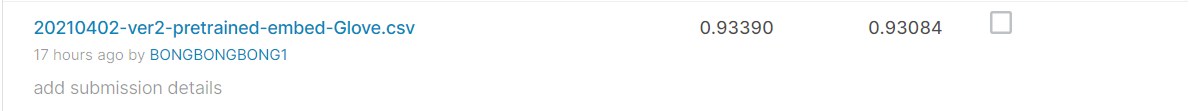